[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciri/iese-dsfb/blob/main/notebooks/110-ComputerVision.ipynb)

# Computer Vision

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

Today, we'll explore how computers can detect patterns in images like defects or edges. We'll start with simple kernel filters - a way to process images by looking at each pixel and its neighbors. Then, we'll see how modern deep learning approaches automate this process, learning complex patterns from examples. Finally, we'll examine the business case from Haiteng Engineering, where we'll analyze whether implementing an automated quality control system makes financial sense. By the end of this session, you'll understand the technical foundations of image analysis and how it can lead to practical business implications in manufacturing

## Image Manipulation

The color to black-and-white manipulation is a simple example of an image filter. By manipulating the pixels, we obtain new - sometimes unexpectedly exciting - results. Let's load another image and create some filters for a potential new Instagram competitor ;). To keep things simple we'll work on the black-and-white version of the image which you can [download here](https://raw.githubusercontent.com/ciri/iese-dsfb/main/images/elephants.jpg).

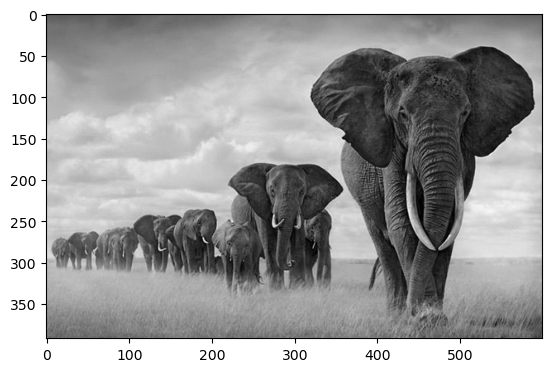

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests

%matplotlib inline

# Load the image in a numpy array.
url = 'https://raw.githubusercontent.com/ciri/iese-dsfb/main/images/elephants.jpg'
raw_image = cv2.imdecode(np.frombuffer(requests.get(url).content, np.uint8), cv2.IMREAD_COLOR)
im = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.show()

In [3]:
im.shape

(392, 600)

In order to be able to see the results of the amazing filters that we are going to build, we first define a function. You shouldn't worry too much about the implementation at this point.

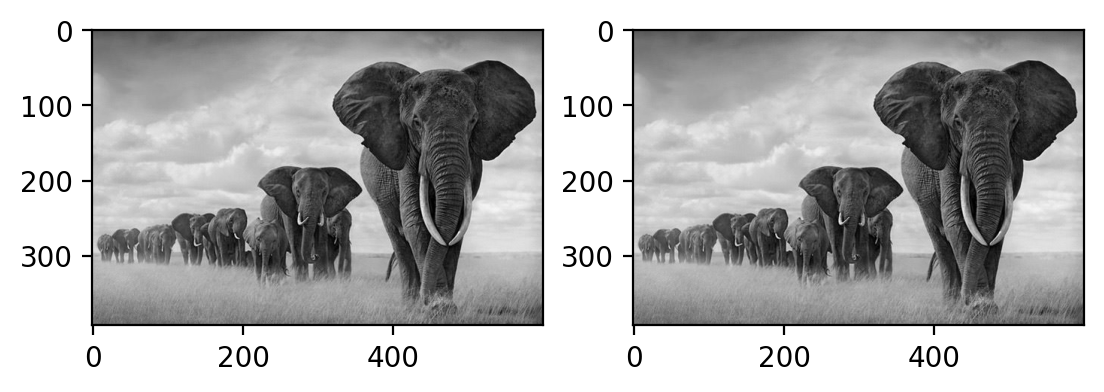

In [4]:
def plot_side_by_side(im1, im2):
    # Renormalize in case values are out of range
    if im2.min() < 0 or im2.max() > 255:
        im2 = ((im2 - im2.min()) / (im2.max() - im2.min()) * 255).astype(np.uint8)

    
    fig, axs = plt.subplots(1,2, dpi=200)
    axs[0].imshow(im1, cmap='gray', vmin=0, vmax=255)
    axs[1].imshow(im2, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
plot_side_by_side(im, im)

Going forward, we'll use the left part to show the original and the right part to show the transformation.

### Kernel Filters

Some of the most exciting image filters are based on the principle of **kernel convolution**. Imagine running your fingertips over a surface to detect changes - you might feel a bump, an edge, or a smooth transition. This is exactly how kernel filters work in image processing. Just as your hand doesn't feel just one point but rather a small area at once, these filters look at each pixel along with its neighbors. By comparing each pixel to its surrounding area in different ways (like taking averages or looking for differences), we can detect features like edges, smooth out noise, or enhance certain patterns. Depending on how we tell these 'digital fingers' to compare pixels with their neighbors, we can achieve different effects from smoothing out imperfections (blur) to  finding sharp edges (edge detection).

### Blur

A classic example is the "blur" which helps to create an air of mistery around the picture. To blur, we replace every pixel by the average of its neigbours. For instance, if we have a 3x3 image with the red focal pixel:

<pre>
5 2 1
3 <font color='red'>1</font> 9
8 7 2
</pre>

Its value would be replaced by (5+2+1+3+1+9+8+7+2)/9 = 3.66. For larger images, we would apply this to every pixel in the image. We could do this manually using for loops, but that would be ... slow. Let's be lazy and use the ``convolve2d`` function from the ``scipy`` libary instead. Not only is this a one-liner, it also runs blazingly fast!

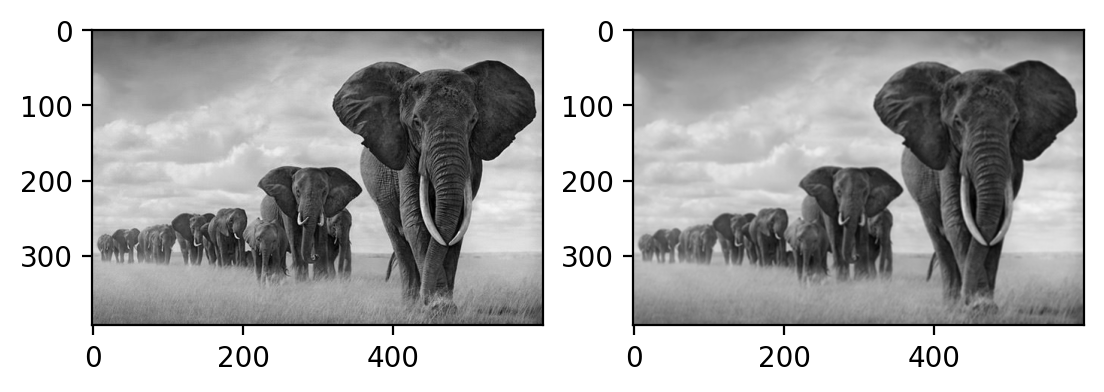

In [5]:
from scipy.signal import convolve2d

weights = [
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
]

im_filtered = convolve2d(im, weights, mode='same')

plot_side_by_side(im, im_filtered)

It's hard to see, but when you focus on the grass, you see that the grass is a bit less sharp. Here's a visualization of what the `convolve2d` function just did for us.

1. We start with a picture like the elephant picture, visualized as a matrix on the left.
2. The kernel (white matrix in the center) is multiplied with a specific region in the picture (highlighted blue on the left).
3. Each time such a multiplication is done, we get 1 output number (blue on the right).

Note that the output image on the right is somewhat smaller because we have an 'edge case' here (edges are not included in the final result because they have no neigbours).

<center>
    <img src="https://raw.githubusercontent.com/ciri/iese-dsfb/main/images/convolution.gif" width="50%">
</center>

**You try it**

Increase the blur by repeatedly applying the filter.

You can increase the effect by taking a larger neighborhood of, say, 4 pixels above/below (8*8 in total). Let's also use the  `np.ones(size)` function instead of typing out the large matrix.

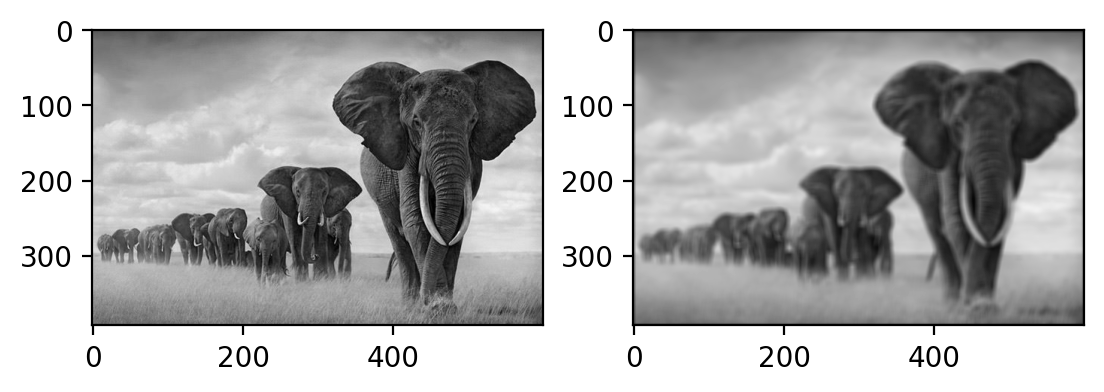

In [6]:
weights     = np.ones((8,8)) / 64
im_filtered = convolve2d(im, weights, mode='same')
plot_side_by_side(im, im_filtered)

### Edge detection

Often, we will want to be able to detect things in images: number of people, faces of people, defects in a product, etc. A first step to object detection is to apply **edge detection**. 

A simply trick we can use is to use a kernel, but just take into consideration anything on the left and the right. This way, you will detect strong changes in the horizontal direction:

<pre>
        -1 0 1 
        -2 0 2
        -1 0 1
</pre>         

To use the hand analogy: just as your fingertips can feel a sudden change in height when running across the edge of a table, this filter detects sudden changes in brightness between neighboring pixels. The negative numbers on the left and positive numbers on the right act like fingertips detecting the 'step up' or 'step down' in pixel values from left to right. 

Try programming applying the above filter to the image.

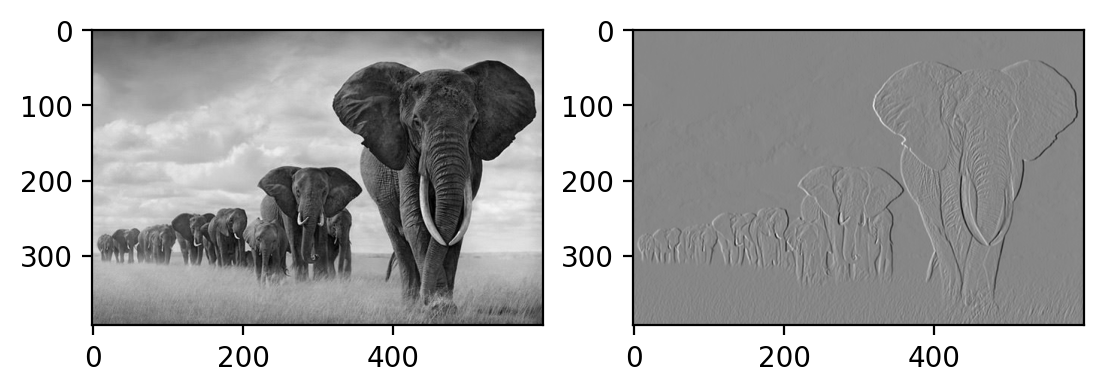

In [7]:
from scipy.signal import convolve2d

weight_edge_hor = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

im_edge_hor = convolve2d(im, weight_edge_hor, mode='same')
plot_side_by_side(im,im_edge_hor);

White means that the it's detecting an edge from left to right, black means that it's detecting an edge from right to left. Grey means nothing was detected.

We can achieve a similar effect for the horizontal direction:

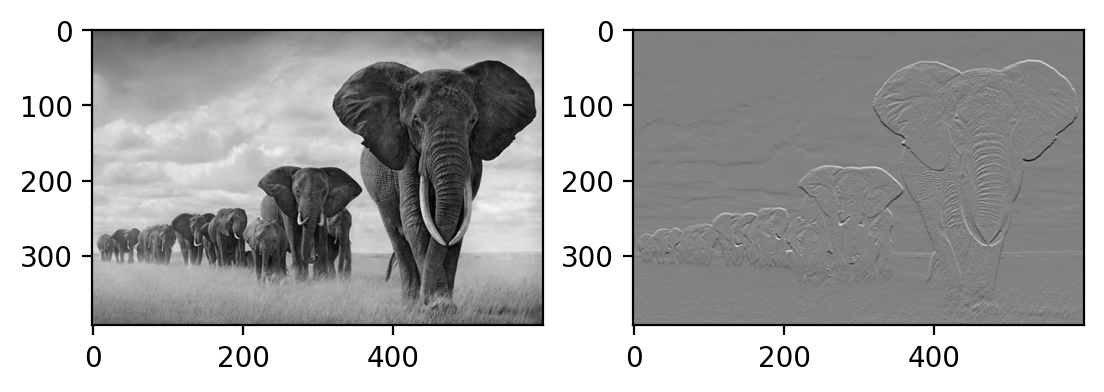

In [8]:
from scipy.signal import convolve2d
weight_edge_ver = [
    [-1,-2,-1],
    [ 0, 0, 0],
    [ 1, 2, 1]
]

# alternatively:
weight_edge_ver = np.array(weight_edge_hor).T

im_edge_ver = convolve2d(im, weight_edge_ver, mode='same')
plot_side_by_side(im,im_edge_ver);

If we want to detect all edges, we can apply the Sobel formula which we program here without worrying about the mathematical detail.

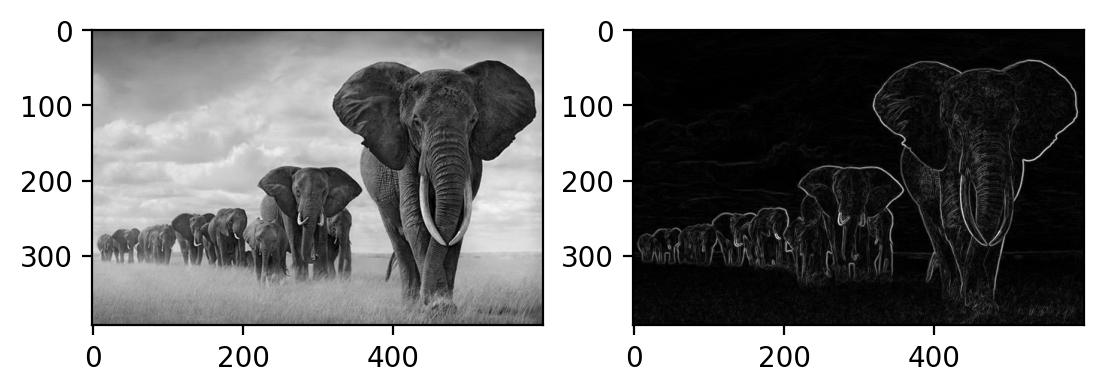

In [9]:
im_edge = np.sqrt(im_edge_hor**2 + im_edge_ver**2)

plot_side_by_side(im,im_edge);

## Bonus Excercise: PyNstagram

As a final exercises for today, try applying your favourite filter from above using the code below. Before you run the code, pay attention to the following:

1. <font color='red' style='font-weight:bold'>Once you run the code, a window will appear. You can only exit this window by pressing 'q'. Anything else may block your computer, so save anything first and assume you may need to reboot your system!</font>
2. You don't need to understand the whole code for the purpose of this exercise. You are only asked to edit the filter code.
3. Make sure that your image's pixels are in the range of 0-255 or you will get strange artifacts.

In [12]:
# Your filter implementation goes here.
def my_filter(im):
    
    #nofilter ;)
    
    # define your filter here!
    # ...
    # end of your filter
    
    return im

In [13]:
### Boilerplate code to get the filter running, don't change me
# First, we get the camera device from your computer
cv2.startWindowThread()
camera = cv2.VideoCapture(0)

try:
    while True:
        # Capture frame-by-frame
        ret, im = camera.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Convert to grayscale
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Resize for performance if you're working on a slow computer
        resize_factor = 1
        im = cv2.resize(im, (int(im.shape[1]/resize_factor), 
                            int(im.shape[0]/resize_factor)))

        # Apply filter
        im = my_filter(im)

        # Display the result
        cv2.imshow('Pynstagram v1.0', im.astype(np.uint8))
        
        # Break loop with 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    # Clean up, release camera etc.
    camera.release()
    cv2.destroyAllWindows()
    for i in range(4):
        cv2.waitKey(1)


QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is not the object's thread (0x31fdb550).
Cannot move to target thread (0x33c7b720)

QObject::moveToThread: Current thread (0x33c7b720) is n

Here's an interesting one:

In [ ]:
# Edge Detection and Other Basic Examples
weight_edge_hor = [
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]
weight_edge_ver = [
    [-1,-2,-1],
    [ 0, 0, 0],
    [ 1, 2, 1]
]

# Your filter implementation goes here.
def my_filter(im):
    # Dreamy brightness
    #im = im.astype(np.uint32) * 2
    #im = np.clip(im,0,255)
    
    # Blur
    #weights = np.ones((8,8))/64
    #im = convolve2d(im, weights, mode='same')

    # Edge detection
    im_edge_ver = convolve2d(im, weight_edge_hor, mode='same')
    im_edge_hor = convolve2d(im, weight_edge_ver, mode='same')
    im = np.sqrt(im_edge_hor**2 + im_edge_ver**2)
    
    
    return im

# Bonus Application: Facial Recognition

What we have learned so far is the basis of computer vision, which we'll talk more about in the next class. To get a feeling, try out the following example which does face detection. It requires that you download a predefined filter (it's quite large matrix of numbers!) which you can [download from here](https://raw.githubusercontent.com/ciri/iese-dsfb/main/resources/haarcascade_frontalface_default.xml). 

Note, this filter is called a [Haar filter](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf), which is like the edge detection that we did, but with some extra mathematical bells and whistles to it. This is one, specifically, is coupled with routines to be able to detect the position of a face in an image.

In [18]:
# Face Detection

import numpy as np
import cv2

def my_filter(im):
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('../resources/haarcascade_frontalface_default.xml')

    # Detect faces - assumes grayscale
    faces = face_cascade.detectMultiScale(im, 1.1, 4)
    
    # Draw rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(im, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return im

### Boilerplate code to get the filter running, don't change me
# First, we get the camera device from your computer
camera = cv2.VideoCapture(0)
cv2.startWindowThread()

while(True):
    # Capture frame-by-frame the R,G,B values of the camera
    ret, im = camera.read()
    
    # We work on grayscale by default, but you can uncomment
    # this line to get the full color spectrum.
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Here, we resized the image to ensure that the your computer
    # can handle the calculations in real-time. You may have to set 
    # the resize factor to 2, or even 4 on your computer depending 
    # on how fast your computer is.
    resize_factor = 1
    im = cv2.resize(im, (int(im.shape[1]/resize_factor), int(im.shape[0]/resize_factor)))
    
    # Now, we apply the filter that you created to the image
    im = my_filter(im)
    
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

    cv2.imshow('Face Detection v1.0', im.astype(np.uint8))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()
cv2.waitKey(1);